In [1]:
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
%tensorflow_version 2.x
import numpy as np
import os
import time 
import datetime
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip '/content/drive/My Drive/Colab Notebooks/Final project/data/dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: aquarium/00000001.jpg   
  inflating: aquarium/00000002.jpg   
  inflating: aquarium/00000003.jpg   
  inflating: aquarium/00000004.jpg   
  inflating: aquarium/00000005.jpg   
  inflating: aquarium/00000006.jpg   
  inflating: aquarium/00000007.jpg   
  inflating: aquarium/00000008.jpg   
  inflating: aquarium/00000009.jpg   
  inflating: aquarium/00000010.jpg   
  inflating: aquarium/00000011.jpg   
  inflating: aquarium/00000012.jpg   
  inflating: aquarium/00000013.jpg   
  inflating: aquarium/00000014.jpg   
  inflating: aquarium/00000015.jpg   
  inflating: aquarium/00000016.jpg   
  inflating: aquarium/00000017.jpg   
  inflating: aquarium/00000018.jpg   
  inflating: aquarium/00000019.jpg   
  inflating: aquarium/00000020.jpg   
  inflating: aquarium/00000021.jpg   
  inflating: aquarium/00000022.jpg   
  inflating: aquarium/00000023.jpg   
  inflating: aquarium/00000024.jpg   
  inflating: aquarium/00000025.jpg   

In [5]:
# The batch size we'll use for training
batch_size = 32

# Size of the image required to train our model
img_size = 120

location = 'aquarium'
x = []
y = []
for image_file in os.listdir(location):
    rgb_image = Image.open(os.path.join(location, image_file )).resize(( img_size, img_size ))

    # Normalize the RGB image array
    rgb_img_array = (np.asarray(rgb_image)) / 255
    gray_image = rgb_image.convert('L')
    # Normalize the grayscale image array
    gray_img_array = ( np.asarray( gray_image ).reshape( ( img_size , img_size , 1 ) ) ) / 255
    # Append both the image arrays
    x.append(gray_img_array)
    y.append(rgb_img_array)

# Splitting the dataset into train and test
train_x, test_x, train_y, test_y = train_test_split(np.array(x), np.array(y), test_size=0.1)

# Construct tf.data.Dataset object
dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
dataset = dataset.batch(batch_size)

In [6]:
def generator_model():
    inputs = tf.keras.layers.Input(shape=( img_size , img_size , 1 ) )

    conv1 = tf.keras.layers.Conv2D(16, kernel_size=(5, 5), strides=1, dilation_rate=4)( inputs )
    conv1 = tf.keras.layers.LeakyReLU()(conv1)
    conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=1, dilation_rate=2)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()(conv1)
    conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()(conv1)

    conv2 = tf.keras.layers.Conv2D(32, kernel_size=(5, 5), strides=1)( conv1 )
    conv2 = tf.keras.layers.LeakyReLU()(conv2)
    conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=1)( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()(conv2)
    conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=1)( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()(conv2)

    conv3 = tf.keras.layers.Conv2D(64 , kernel_size=(5, 5) , strides=1)( conv2 )
    conv3 = tf.keras.layers.LeakyReLU()(conv3)
    conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1)( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()(conv3)
    conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1)( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()(conv3)

    bottleneck = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1, activation='relu', padding='same')(conv3)

    concat_1 = tf.keras.layers.Concatenate()([bottleneck, conv3])
    conv_up_3 = tf.keras.layers.Conv2DTranspose(128, kernel_size=( 3 , 3 ), strides=1, activation='relu')(concat_1)
    conv_up_3 = tf.keras.layers.Conv2DTranspose(128, kernel_size=( 3 , 3 ), strides=1, activation='relu')(conv_up_3)
    conv_up_3 = tf.keras.layers.Conv2DTranspose(64, kernel_size=(5 , 5 ), strides=1, activation='relu')(conv_up_3)

    concat_2 = tf.keras.layers.Concatenate()([conv_up_3 , conv2 ])
    conv_up_2 = tf.keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=1, activation='relu')(concat_2)
    conv_up_2 = tf.keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=1, activation='relu')(conv_up_2)
    conv_up_2 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(5, 5), strides=1, activation='relu')(conv_up_2)

    concat_3 = tf.keras.layers.Concatenate()([conv_up_2 , conv1])
    conv_up_1 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=1, activation='relu')(concat_3)
    conv_up_1 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=1, activation='relu', dilation_rate=2)(conv_up_1)
    conv_up_1 = tf.keras.layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=1, activation='relu', dilation_rate=4)(conv_up_1)

    model = tf.keras.models.Model(inputs, conv_up_1)
    model.summary()
    return model


In [7]:
def discriminator_model():
    layers = [
        tf.keras.layers.Conv2D(32, kernel_size=(7, 7), strides=1 , activation='relu', input_shape=(120, 120, 3)),
        tf.keras.layers.Conv2D(32, kernel_size=(7, 7), strides=1, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, kernel_size=(5, 5), strides=1, activation='relu'),
        tf.keras.layers.Conv2D(64, kernel_size=(5, 5), strides=1, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1, activation='relu'),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), strides=1, activation='relu'),
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), strides=1, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid') 
    ]
    model = tf.keras.models.Sequential(layers)
    model.summary()
    return model

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) - tf.random.uniform( shape=real_output.shape , maxval=0.1), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output) + tf.random.uniform( shape=fake_output.shape , maxval=0.1), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output , real_y):
    real_y = tf.cast( real_y, 'float32')
    return mse( fake_output, real_y)

#Change according to the paper
generator_optimizer = tf.keras.optimizers.Adam(0.001)
discriminator_optimizer = tf.keras.optimizers.Adam(0.001)

#try class and object instantiation 
generator = generator_model()
discriminator = discriminator_model()


In [9]:
#Declaration of some hyperparameters
EPOCHS = 25

#To track Generator and Discriminator lossses over epochs
gen_losses = []
disc_losses = []

In [10]:
@tf.function
def train_step(input_x, real_y):
   
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generates an image -> G( x )
        generated_images = generator( input_x , training=True)

        # Probability that the given image is real -> D( x )
        real_output = discriminator( real_y, training=True)

        # Probability that the given image is the one generated -> D( G( x ) )
        generated_output = discriminator(generated_images, training=True)
        
        # Generator Loss L2 Loss -> || y - G(x) ||^2
        gen_loss = generator_loss( generated_images , real_y )
        # Discriminator loss
        disc_loss = discriminator_loss( real_output, generated_output )

    # Calculating the gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Optimizing with Adam
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss


In [11]:
#training function
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for (input_x , real_y ) in dataset:
      gen_loss, disc_loss = train_step(input_x,real_y)

    template = 'Epoch {}, Time {}, Generator Loss: {}, Discriminator Loss: {}'
    print (template.format(epoch+1,
                         time.time()-start,
                         gen_loss, 
                         disc_loss))
    
    gen_losses.append(gen_loss)
    disc_losses.append(disc_loss)  


In [12]:
#Training function call
train(dataset, EPOCHS)

Epoch 1, Time 115.68281817436218, Generator Loss: 0.023645389825105667, Discriminator Loss: 0.6111432313919067
Epoch 2, Time 64.52510523796082, Generator Loss: 0.01991558074951172, Discriminator Loss: 1.1524996757507324
Epoch 3, Time 64.24213027954102, Generator Loss: 0.018094763159751892, Discriminator Loss: 0.6078375577926636
Epoch 4, Time 64.23811650276184, Generator Loss: 0.01636117696762085, Discriminator Loss: 0.9326040744781494
Epoch 5, Time 64.15534567832947, Generator Loss: 0.015711713582277298, Discriminator Loss: 0.6225012540817261
Epoch 6, Time 63.97109866142273, Generator Loss: 0.015110842883586884, Discriminator Loss: 0.7972154021263123
Epoch 7, Time 64.36723065376282, Generator Loss: 0.014342542737722397, Discriminator Loss: 0.8412216901779175
Epoch 8, Time 64.32783126831055, Generator Loss: 0.01386207900941372, Discriminator Loss: 0.6876991391181946
Epoch 9, Time 64.32278442382812, Generator Loss: 0.013530444353818893, Discriminator Loss: 0.7098550796508789
Epoch 10, Ti

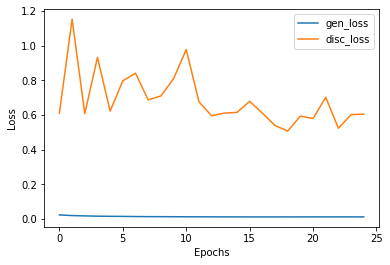

In [13]:
#Visualization of the losses

plt.figure()
line1, = plt.plot(gen_losses)
line2, = plt.plot(disc_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend((line1,line2),("gen_loss","disc_loss"))
plt.show()

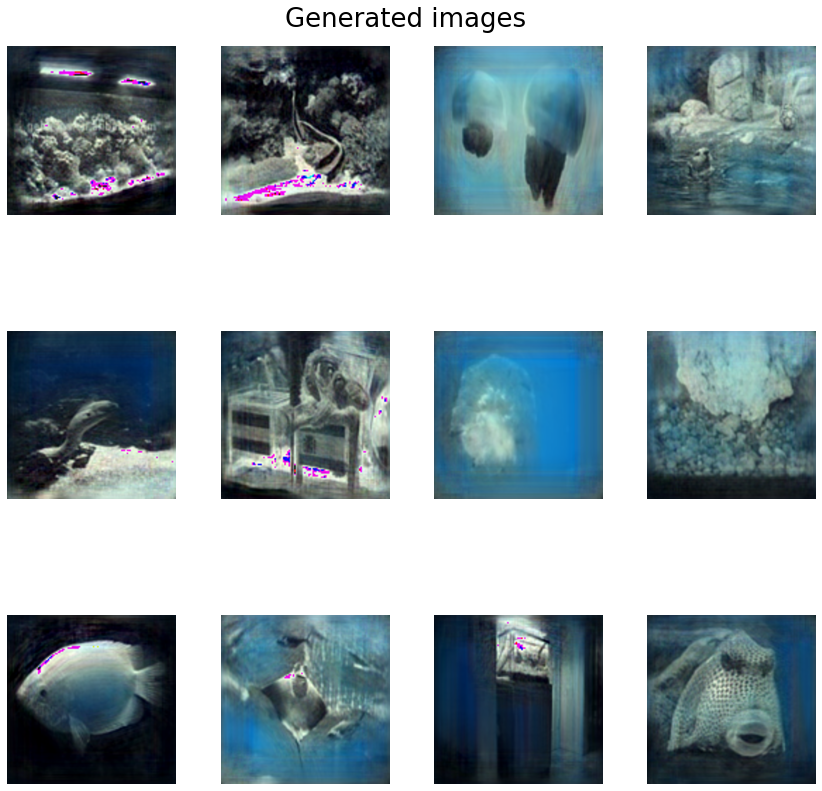

In [15]:
y = generator(test_x[ 0 : 12 ] ).numpy()
fig, ax = plt.subplots(3, 4, figsize=(12,12))
fig.suptitle('Generated images', fontsize=26)
fig.tight_layout()
ax = ax.flatten()
for i in range(12):
  image = Image.fromarray( (y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  image = np.asarray( image )
  ax[i].imshow(image)
  ax[i].axis("off")
  

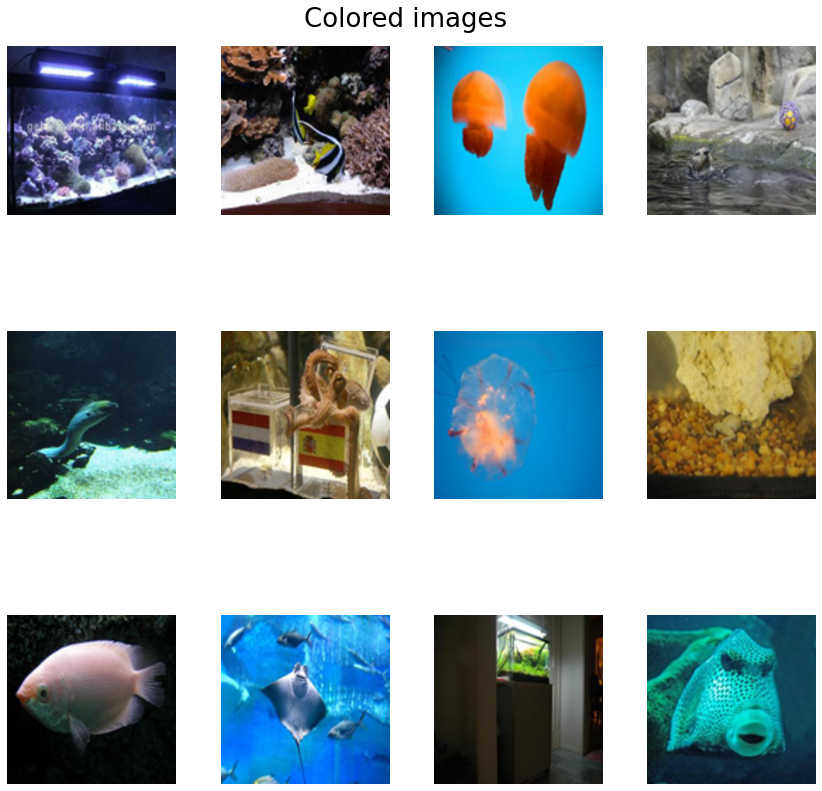

In [16]:
fig, ax = plt.subplots(3, 4,figsize=(12,12))
fig.suptitle('Colored images', fontsize=26)
fig.tight_layout()
ax = ax.flatten()
for i in range(12):
  image = Image.fromarray( ( test_y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  image = np.asarray( image )
  ax[i].imshow(image)
  ax[i].axis("off")


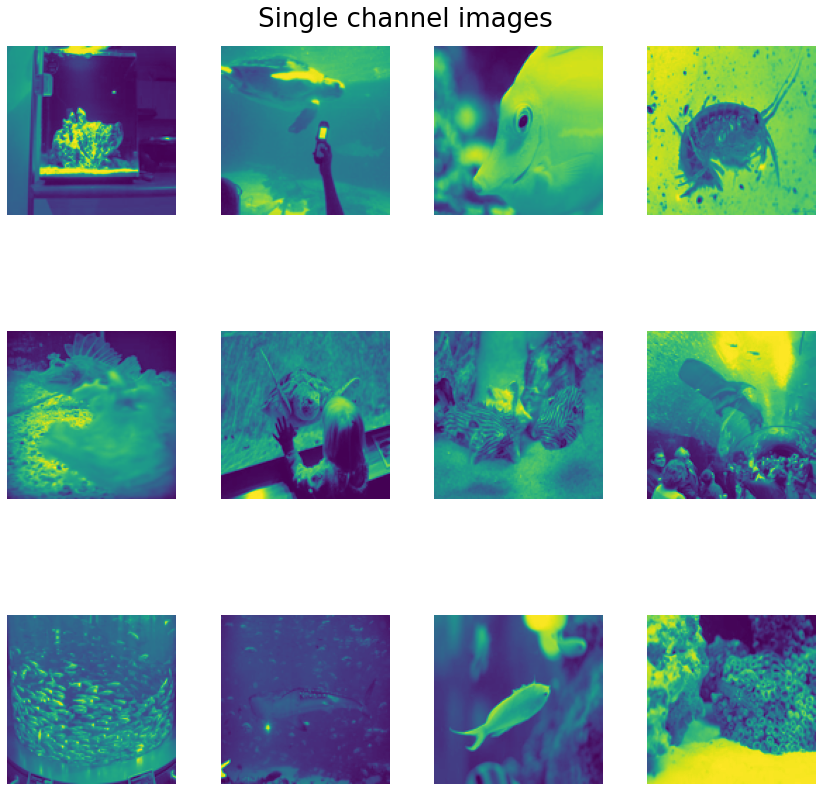

In [45]:
fig, ax = plt.subplots(3 ,4,figsize=(12,12))
fig.suptitle('Single channel images', fontsize=26)
fig.tight_layout()
ax = ax.flatten()
for i in range(12):
  ax[i].imshow(test_x[i].reshape((120,120)))
  ax[i].axis("off")
